In [1]:
# === CNT Lab Smoketest: save → manifest → verify ==============================
import os, time, math, json, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cntlab as cl

# 0) Init (seeds, logger, paths)
cl.nb.init()

# 1) Generate tiny artifacts
ts = time.strftime("%Y-%m-%d %H:%M:%S")
rng = np.random.default_rng(1337)
x   = np.linspace(0, 2*np.pi, 200)
y   = np.sin(x) + 0.05*rng.standard_normal(len(x))

df = pd.DataFrame({"x": x, "y": y})

metrics = {
    "smoketest": True,
    "timestamp": ts,
    "n_rows_df": int(df.shape[0]),
    "mean_y": float(np.mean(y)),
    "std_y":  float(np.std(y, ddof=1)),
}

# 2) Save via cntlab (uses deterministic names + manifest logging)
#    NOTE: we rely on default tags = [module, dataset, <type>]
m_json = cl.io.save_json(metrics, module="smoke", dataset="demo", desc="metrics_example")
t_csv  = cl.io.save_df(df,      module="smoke", dataset="demo", desc="table_example", fmt="csv")

fig, ax = plt.subplots()
ax.plot(x, y)
ax.set_xlabel("x")
ax.set_ylabel("y = sin(x) + noise")
ax.set_title("CNTLab Smoketest Figure")
f_png = cl.io.save_figure(fig,  module="smoke", dataset="demo", desc="figure_example")
plt.close(fig)

# 3) Fetch back from manifest by kind + tags (module/dataset)
def grab(kind, *tags, any=False):
    q = {"kind": kind}
    if any:  q["tags_any"] = list(tags)
    else:    q["tags_all"] = list(tags)
    hits = cl.manifest.find_artifacts(**q)
    assert hits, f"No artifacts for kind={kind} tags={tags}"
    return hits[-1]["path"]

latest_metrics = grab("metrics", "smoke", "demo")
latest_table   = grab("table",   "smoke", "demo")
latest_figure  = grab("figure",  "smoke", "demo")

# 4) Verify they landed on the right shelves
P = cl.P
def _assert_under(path_str, root):
    path = os.path.abspath(path_str)
    root = os.path.abspath(root)
    assert path.startswith(root), f"Expected under {root}, got {path}"
    return path

m_path = _assert_under(latest_metrics, P.metrics)
t_path = _assert_under(latest_table,   P.tables)
f_path = _assert_under(latest_figure,  P.figures)

for p in [m_path, t_path, f_path]:
    assert os.path.exists(p), f"Missing file: {p}"

# 5) Print a tidy report
print("== CNTLab Smoketest OK ==")
print("Metrics →", m_path)
print("Table   →", t_path)
print("Figure  →", f_path)

# 6) Bonus: show the last manifest record for metrics
rec = cl.manifest.find_artifacts(kind="metrics", tags_all=["smoke","demo"])[-1]
print("\nLast metrics manifest entry:")
print(json.dumps(rec, indent=2))


[2025-10-08 20:27:24,574] INFO cntlab: CNTLab notebook initialized
[2025-10-08 20:27:24,576] INFO cntlab: CNT Paths(root=C:\Users\caleb\CNT_Lab)


→ CNTLab ready.
   Root: C:\Users\caleb\CNT_Lab
   Figures: C:\Users\caleb\CNT_Lab\artifacts\figures
   Tables: C:\Users\caleb\CNT_Lab\artifacts\tables
   Metrics: C:\Users\caleb\CNT_Lab\artifacts\metrics
== CNTLab Smoketest OK ==
Metrics → C:\Users\caleb\CNT_Lab\artifacts\metrics\smoke__demo__metrics_example__20251008-202724.json
Table   → C:\Users\caleb\CNT_Lab\artifacts\tables\smoke__demo__table_example__20251008-202724.csv
Figure  → C:\Users\caleb\CNT_Lab\artifacts\figures\smoke__demo__figure_example__20251008-202724.png

Last metrics manifest entry:
{
  "ts": "2025-10-09T00:27:24Z",
  "kind": "metrics",
  "path": "C:\\Users\\caleb\\CNT_Lab\\artifacts\\metrics\\smoke__demo__metrics_example__20251008-202724.json",
  "size": 154,
  "sha256": "24575c4849846af771720e6ef666fdbe418a439d9e1af2345e18b0350887d152",
  "tags": [
    "smoke",
    "demo",
    "json"
  ],
  "meta": {}
}


[2025-10-08 20:29:08,166] INFO cntlab: CNTLab notebook initialized
[2025-10-08 20:29:08,167] INFO cntlab: CNT Paths(root=C:\Users\caleb\CNT_Lab)


→ CNTLab ready.
   Root: C:\Users\caleb\CNT_Lab
   Figures: C:\Users\caleb\CNT_Lab\artifacts\figures
   Tables: C:\Users\caleb\CNT_Lab\artifacts\tables
   Metrics: C:\Users\caleb\CNT_Lab\artifacts\metrics
== Round-trip OK ==
Table  → C:\Users\caleb\CNT_Lab\artifacts\tables\migrated__cnt-genomic-resonance-map__df629623.csv
Figure → C:\Users\caleb\CNT_Lab\artifacts\figures\migrated__kuramoto-beta-fit__6c8cafe5.png
Metric → C:\Users\caleb\CNT_Lab\artifacts\metrics\migrated__omni-summary__1ecd150d.json

Table shape: (119718, 10)


,rsid,Chromosome,pos,trait,ccre_id,gene_id,gene_name,tissue_hits,tissues,resonance_score
0,esv2676630,chr16,173448,Glycated hemoglobin levels,EH38E1794437,ENSG00000294455.1,ENSG00000294455,0,NaN,1.0
1,rs10000702,chr4,156771179,"Glucose (fasting status unknown, maximum, inv-...",EH38E2338838,ENSG00000248629.1,ENSG00000248629,0,NaN,1.0
2,rs1000113,chr5,150860514,Crohn's disease,EH38E2421397,ENSG00000237693.6,IRGM,0,NaN,1.0
3,rs1000113,chr5,150860514,Inflammatory bowel disease,EH38E2421397,ENSG00000237693.6,IRGM,0,NaN,1.0
4,rs1000113,chr5,150860514,Ulcerative colitis,EH38E2421397,ENSG00000237693.6,IRGM,0,NaN,1.0



Metrics keys: ['summary']


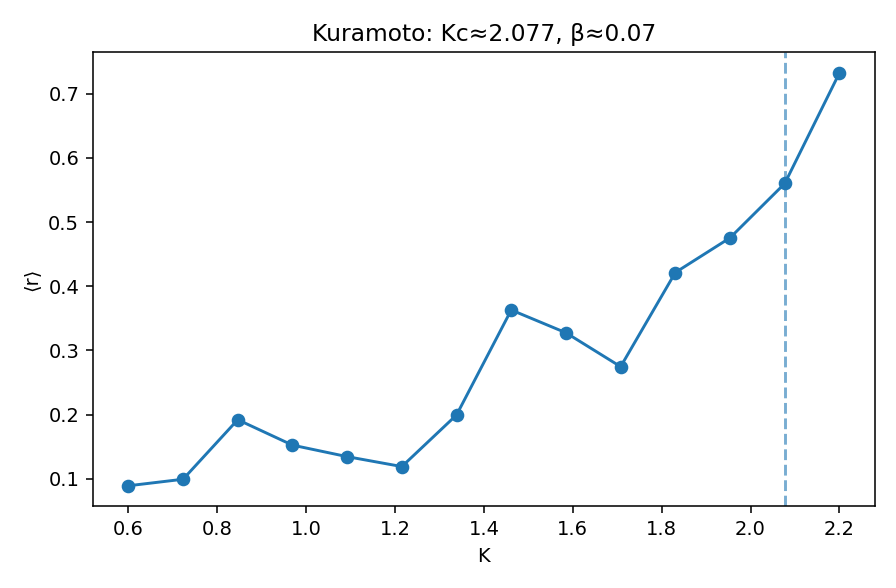

In [2]:
# === CNTLab Artifact Round-Trip Test =========================================
import os, json
from pathlib import Path
import pandas as pd
from IPython.display import display, Image
import cntlab as cl

cl.nb.init()

def latest(kind, tags_all=None, tags_any=None):
    q = {"kind": kind}
    if tags_all: q["tags_all"] = list(tags_all)
    if tags_any: q["tags_any"] = list(tags_any)
    hits = cl.manifest.find_artifacts(**q)
    assert hits, f"No {kind} for tags_all={tags_all} tags_any={tags_any}"
    return hits[-1]["path"]

# Pick representative artifacts; fall back gracefully if a tag isn't present
try:    tbl = latest("table",   tags_all=["cnt-genomic-resonance-map"])
except: tbl = latest("table",   tags_any=["cnt-genomic-resonance-map","cnt-nodes-3d","per-band-edges"])

try:    fig = latest("figure",  tags_all=["kuramoto-beta-fit"])
except: fig = latest("figure",  tags_any=["kuramoto-beta-fit","kuramoto","omni-v8-dashboard","cnt-genomic-graph"])

try:    met = latest("metrics", tags_all=["omni-summary"])
except: met = latest("metrics", tags_any=["omni-summary","metrics","report"])

# Verify shelves
P = cl.P
assert os.path.abspath(tbl).startswith(os.path.abspath(P.tables)),  f"Table not under {P.tables}"
assert os.path.abspath(fig).startswith(os.path.abspath(P.figures)), f"Figure not under {P.figures}"
assert os.path.abspath(met).startswith(os.path.abspath(P.metrics)), f"Metrics not under {P.metrics}"

print("== Round-trip OK ==")
print("Table  →", tbl)
print("Figure →", fig)
print("Metric →", met)

# Peek into the table
if tbl.lower().endswith((".csv",".tsv")):
    df = pd.read_csv(tbl)
    print("\nTable shape:", df.shape)
    display(df.head(5))

# Peek into the metrics JSON
with open(met, "r", encoding="utf-8") as f:
    m = json.load(f)
print("\nMetrics keys:", list(m)[:12])

# Preview the figure (best-effort)
try:
    display(Image(filename=fig))
except Exception as e:
    print("Image preview skipped:", e)


In [3]:
# === CNTLab: Lab Card (session snapshot) =====================================
import os, json, datetime as dt, matplotlib.pyplot as plt
import cntlab as cl
from collections import Counter

cl.nb.init()
P = cl.P

# 1) Count everything by kind
all_kinds = []
for kind in ["figure","table","metrics","model","notebook","blob"]:
    all_kinds += [kind]*len(cl.manifest.find_artifacts(kind=kind))
counts = Counter(all_kinds)

# 2) Grab latest helpful artifacts (best-effort fallbacks)
def latest(kind, tags_all=None, tags_any=None):
    q={"kind":kind}
    if tags_all: q["tags_all"]=list(tags_all)
    if tags_any: q["tags_any"]=list(tags_any)
    hits = cl.manifest.find_artifacts(**q)
    return hits[-1] if hits else None

lab = {
    "timestamp": dt.datetime.utcnow().isoformat()+"Z",
    "root": str(P.root),
    "counts": dict(counts),
    "latest": {
        "kuramoto_figure": latest("figure", tags_any=["kuramoto-beta-fit","kuramoto"]),
        "genome_table":    latest("table",  tags_any=["cnt-genomic-resonance-map","cnt-nodes-3d"]),
        "omni_metrics":    latest("metrics",tags_any=["omni-summary","omni-v8-summary"]),
    }
}

# 3) Save JSON
card_path = cl.io.save_json(lab, module="lab", dataset="card", desc="snapshot", tags=["lab","card"])
print("Lab card JSON →", card_path)

# 4) Minimal PNG “card”
fig, ax = plt.subplots(figsize=(6,3))
ax.bar(list(counts.keys()), list(counts.values()))
ax.set_title("CNTLab Inventory (by kind)")
ax.set_ylabel("count")
for tick in ax.get_xticklabels(): tick.set_rotation(30); tick.set_ha("right")
png_path = cl.io.save_figure(fig, module="lab", dataset="card", desc="inventory_bar")
plt.close(fig)
print("Lab card PNG  →", png_path)


[2025-10-08 20:31:16,866] INFO cntlab: CNTLab notebook initialized
[2025-10-08 20:31:16,867] INFO cntlab: CNT Paths(root=C:\Users\caleb\CNT_Lab)


→ CNTLab ready.
   Root: C:\Users\caleb\CNT_Lab
   Figures: C:\Users\caleb\CNT_Lab\artifacts\figures
   Tables: C:\Users\caleb\CNT_Lab\artifacts\tables
   Metrics: C:\Users\caleb\CNT_Lab\artifacts\metrics
Lab card JSON → C:\Users\caleb\CNT_Lab\artifacts\metrics\lab__card__snapshot__20251008-203116.json
Lab card PNG  → C:\Users\caleb\CNT_Lab\artifacts\figures\lab__card__inventory_bar__20251008-203116.png


C:\Users\caleb\AppData\Local\Temp\ipykernel_29972\1550560128.py:24: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": dt.datetime.utcnow().isoformat()+"Z",


In [4]:
# === CNTLab: fuzzy finder =====================================================
import os, re, json, cntlab as cl
from pathlib import Path

def find_artifacts(query, kind=None, limit=20):
    """
    Search manifest with a loose match on tags OR filename/path.
    """
    hits = []
    kinds = [kind] if kind else ["figure","table","metrics","model","notebook","blob"]
    q = str(query).lower()
    for k in kinds:
        for rec in cl.manifest.find_artifacts(kind=k):
            tags = " ".join(rec.get("tags",[])).lower()
            path = rec.get("path","").lower()
            if q in tags or q in Path(path).name.lower() or q in path:
                hits.append({"kind": k, "path": rec["path"], "tags": rec.get("tags",[]), "ts": rec["ts"]})
    hits = sorted(hits, key=lambda r:r["ts"])[-limit:]
    return hits

# examples:
find_artifacts("kuramoto")[:3]
find_artifacts("genomic-resonance")[:3]
find_artifacts("eeg", kind="figure")[:3]


[{'kind': 'figure',
  'path': 'C:\\Users\\caleb\\CNT_Lab\\artifacts\\figures\\migrated__cnt-eeg-lofc-rsa-superblock-fixed-bars__6e58f4a3.png',
  'tags': ['cnt',
   'cnt-eeg-lofc-rsa-superblock-fixed-bars',
   'eeg',
   'migrated',
   'out',
   'png'],
  'ts': '2025-10-09T00:22:31Z'},
 {'kind': 'figure',
  'path': 'C:\\Users\\caleb\\CNT_Lab\\artifacts\\figures\\migrated__cnt-eeg-lofc-rsa-superblock-fixed-perm__be3f5cc8.png',
  'tags': ['cnt',
   'cnt-eeg-lofc-rsa-superblock-fixed-perm',
   'eeg',
   'migrated',
   'out',
   'png'],
  'ts': '2025-10-09T00:22:31Z'},
 {'kind': 'figure',
  'path': 'C:\\Users\\caleb\\CNT_Lab\\artifacts\\figures\\migrated__cnt-eeg-lofc-rsa-superblock-perm__63a1dd01.png',
  'tags': ['cnt',
   'cnt-eeg-lofc-rsa-superblock-perm',
   'eeg',
   'migrated',
   'out',
   'png'],
  'ts': '2025-10-09T00:22:31Z'}]

In [5]:
# === CNTLab Data Re-Homer: put real inputs in data/raw, arrays in data/interim ==
from pathlib import Path
import shutil, re
import cntlab as cl

cl.nb.init()
P = cl.P

# Ensure target folders exist
RAW = {
    "eeg":          P.root / "data" / "raw" / "eeg",
    "genome_fasta": P.root / "data" / "raw" / "genome_fasta",
    "annotations":  P.root / "data" / "raw" / "annotations",
    "packages":     P.root / "data" / "raw" / "packages",
}
INT = {
    "npy": P.root / "data" / "interim" / "npy",
    "npz": P.root / "data" / "interim" / "npz",
}
for d in [*RAW.values(), *INT.values()]:
    d.mkdir(parents=True, exist_ok=True)

def move_and_log(src: Path, dst_dir: Path, tags_add: list[str], kind="blob"):
    dst = dst_dir / src.name
    shutil.move(str(src), str(dst))
    # Log as a fresh artifact with enriched tags
    base_tags = set(tags_add)
    # add extension tag
    ext = src.suffix.lower().lstrip(".")
    if ext: base_tags.add(ext)
    cl.manifest.log_artifact(dst, kind=kind, tags=sorted(base_tags), meta={"relocated_from": str(src)})
    return dst

moved = []

# Only sweep files that are in artifacts/ root (not figures/tables/metrics/models)
candidates = list(P.artifacts.glob("*"))  # files like migrated__*.*
for src in candidates:
    if not src.is_file():
        continue
    name = src.name.lower()

    # RAW: EEG EDF
    if name.endswith(".edf"):
        moved.append(move_and_log(src, RAW["eeg"], ["raw","eeg"]))
        continue

    # RAW: genome FASTA (fa.gz)
    if name.endswith(".fa.gz"):
        moved.append(move_and_log(src, RAW["genome_fasta"], ["raw","genome","fasta"]))
        continue

    # RAW: annotations (bed.gz / gtf.gz)
    if name.endswith(".bed.gz") or name.endswith(".gtf.gz"):
        moved.append(move_and_log(src, RAW["annotations"], ["raw","annotations"]))
        continue

    # INTERIM: numpy arrays
    if name.endswith(".npy"):
        moved.append(move_and_log(src, INT["npy"], ["interim","array","npy"]))
        continue
    if name.endswith(".npz"):
        moved.append(move_and_log(src, INT["npz"], ["interim","array","npz"]))
        continue

    # RAW bundles
    if name.endswith(".zip") or name.endswith(".rar"):
        moved.append(move_and_log(src, RAW["packages"], ["raw","package"]))
        continue

# Report
print(f"Relocated {len(moved)} data files.")
for p in moved[:12]:
    print("→", p)
if len(moved) > 12:
    print("… and", len(moved)-12, "more")


[2025-10-08 20:35:23,048] INFO cntlab: CNTLab notebook initialized
[2025-10-08 20:35:23,048] INFO cntlab: CNT Paths(root=C:\Users\caleb\CNT_Lab)


→ CNTLab ready.
   Root: C:\Users\caleb\CNT_Lab
   Figures: C:\Users\caleb\CNT_Lab\artifacts\figures
   Tables: C:\Users\caleb\CNT_Lab\artifacts\tables
   Metrics: C:\Users\caleb\CNT_Lab\artifacts\metrics
Relocated 72 data files.
→ C:\Users\caleb\CNT_Lab\data\interim\npy\migrated__atlas-area__03c60558.npy
→ C:\Users\caleb\CNT_Lab\data\interim\npy\migrated__atlas-finalphi__8a3d785a.npy
→ C:\Users\caleb\CNT_Lab\data\interim\npy\migrated__atlas-fracprob__2f2a24d6.npy
→ C:\Users\caleb\CNT_Lab\data\raw\packages\migrated__cnt-cognitivealphabet-bundle__cc7e149f.zip
→ C:\Users\caleb\CNT_Lab\data\raw\packages\migrated__cnt-proof-out__19f2fc73.rar
→ C:\Users\caleb\CNT_Lab\data\interim\npy\migrated__gede-best-curve-v2__67e1b04f.npy
→ C:\Users\caleb\CNT_Lab\data\interim\npy\migrated__gede-best-curve__74444f87.npy
→ C:\Users\caleb\CNT_Lab\data\raw\eeg\migrated__s001-s001r10__20de1c77.edf
→ C:\Users\caleb\CNT_Lab\data\raw\eeg\migrated__s001-s001r13__dde64623.edf
→ C:\Users\caleb\CNT_Lab\data\raw\eeg

In [6]:
# examples
cl.manifest.find_artifacts(kind="blob", tags_all=["raw","eeg"])[:2]
cl.manifest.find_artifacts(kind="blob", tags_all=["raw","genome","fasta"])[:2]
cl.manifest.find_artifacts(kind="blob", tags_all=["interim","npy"])[:2]


[{'ts': '2025-10-09T00:35:23Z',
  'kind': 'blob',
  'path': 'C:\\Users\\caleb\\CNT_Lab\\data\\interim\\npy\\migrated__atlas-area__03c60558.npy',
  'size': 1128,
  'sha256': '03c60558998fd573134b0401f0e08f18fa3e051c4ee7d013d9436747f6164716',
  'tags': ['array', 'interim', 'npy'],
  'meta': {'relocated_from': 'C:\\Users\\caleb\\CNT_Lab\\artifacts\\migrated__atlas-area__03c60558.npy'}},
 {'ts': '2025-10-09T00:35:23Z',
  'kind': 'blob',
  'path': 'C:\\Users\\caleb\\CNT_Lab\\data\\interim\\npy\\migrated__atlas-finalphi__8a3d785a.npy',
  'size': 1128,
  'sha256': '8a3d785a5d6e84bd94a364cf77f41ea8e8aea4279022a8144fa7f63ead01fdc5',
  'tags': ['array', 'interim', 'npy'],
  'meta': {'relocated_from': 'C:\\Users\\caleb\\CNT_Lab\\artifacts\\migrated__atlas-finalphi__8a3d785a.npy'}}]

In [7]:
# === Build Data Catalog from Manifest ========================================
import json, pandas as pd
from pathlib import Path
import cntlab as cl

cl.nb.init(); P = cl.P

rows = []
for kind in ["blob"]:
    for rec in cl.manifest.find_artifacts(kind=kind):
        t = set(rec.get("tags", []))
        if "raw" in t or "interim" in t:
            rows.append({
                "ts": rec["ts"],
                "kind": rec["kind"],
                "path": rec["path"],
                "size": rec.get("size"),
                "sha256": rec.get("sha256"),
                "tags": ";".join(sorted(t))
            })

df = pd.DataFrame(rows).sort_values("ts")
csv_path = cl.io.save_df(df, module="inventory", dataset="data", desc="catalog", fmt="csv", tags=["inventory","data"])
catalog = {}
for r in rows:
    tags = r["tags"].split(";")
    key  = "|".join(sorted([t for t in tags if t not in {"raw","interim"}])[:4]) or "untagged"
    catalog.setdefault(key, []).append({"path": r["path"], "tags": tags, "sha256": r["sha256"]})

(P.root/"configs").mkdir(exist_ok=True, parents=True)
json_path = P.root/"configs"/"data_catalog.json"
json_path.write_text(json.dumps(catalog, indent=2), encoding="utf-8")

print("Catalog JSON →", json_path)
print("Inventory CSV →", csv_path)
print("Rows:", len(df))
df.tail(8)


[2025-10-08 20:37:42,273] INFO cntlab: CNTLab notebook initialized
[2025-10-08 20:37:42,273] INFO cntlab: CNT Paths(root=C:\Users\caleb\CNT_Lab)


→ CNTLab ready.
   Root: C:\Users\caleb\CNT_Lab
   Figures: C:\Users\caleb\CNT_Lab\artifacts\figures
   Tables: C:\Users\caleb\CNT_Lab\artifacts\tables
   Metrics: C:\Users\caleb\CNT_Lab\artifacts\metrics
Catalog JSON → C:\Users\caleb\CNT_Lab\configs\data_catalog.json
Inventory CSV → C:\Users\caleb\CNT_Lab\artifacts\tables\inventory__data__catalog__20251008-203742.csv
Rows: 72


,ts,kind,path,size,sha256,tags
58,2025-10-09T00:35:42Z,blob,C:\Users\caleb\CNT_Lab\data\raw\eeg\migrated__...,2555616,9707099fbc3c9bb8cd9655c9ac491b5c6eb0383ea2a179...,edf;eeg;raw
62,2025-10-09T00:35:42Z,blob,C:\Users\caleb\CNT_Lab\data\raw\eeg\migrated__...,2555616,33060662f7551cba7035f177f88442594250cf4359da7d...,edf;eeg;raw
61,2025-10-09T00:35:42Z,blob,C:\Users\caleb\CNT_Lab\data\raw\eeg\migrated__...,2555616,c6665f0c93288610a0f3cc379edb8064072e7b27672235...,edf;eeg;raw
60,2025-10-09T00:35:42Z,blob,C:\Users\caleb\CNT_Lab\data\raw\eeg\migrated__...,2555616,6ecfb972c81f97b5bc88a292b9b249b4fbd3c51f1959ca...,edf;eeg;raw
59,2025-10-09T00:35:42Z,blob,C:\Users\caleb\CNT_Lab\data\raw\eeg\migrated__...,2555616,19c943fb32f7749b7e37d8765f84a3bbf76c4ac7ea48ff...,edf;eeg;raw
70,2025-10-09T00:35:42Z,blob,C:\Users\caleb\CNT_Lab\data\raw\eeg\migrated__...,2555616,10e642cfacf5d55a4a90b73f8968e2dc4da6db4b845838...,edf;eeg;raw
63,2025-10-09T00:35:42Z,blob,C:\Users\caleb\CNT_Lab\data\raw\eeg\migrated__...,2555616,eeeeb3a1fad45ab52993a7696c8f86b0f4cb7de3aa68a6...,edf;eeg;raw
71,2025-10-09T00:35:42Z,blob,C:\Users\caleb\CNT_Lab\data\raw\eeg\migrated__...,2555616,138893d950405102e1536365290ac15255688eaab18117...,edf;eeg;raw


In [8]:
# === Convenience data loaders ================================================
from pathlib import Path
import json, gzip, pandas as pd, numpy as np

def load_csv(path, **kw):   return pd.read_csv(path, **kw)
def load_tsv(path, **kw):   return pd.read_csv(path, sep="\t", **kw)
def load_npy(path):         return np.load(path)
def load_npz(path):         return np.load(path)
def load_gtf(path):         return pd.read_csv(path, sep="\t", comment="#", header=None, low_memory=False)
def load_bed_gz(path):      return pd.read_csv(path, sep="\t", header=None, compression="gzip")
def load_fasta_gz_head(path, n=5):
    out=[]; 
    with gzip.open(path, "rt") as f:
        for i, line in enumerate(f):
            if i>=n: break
            out.append(line.rstrip())
    return out

def load_edf(path):
    try:
        import mne
    except ImportError:
        raise ImportError("pip install mne to read EDF files")
    return mne.io.read_raw_edf(path, preload=False)

# Examples (adjust to taste)
# df = load_csv(grab("table", "cnt-genomic-resonance-map"))
# sig = load_fasta_gz_head(grab("blob","raw","genome","fasta"))


In [9]:
# — Retag EEG + genome families, idempotent —
import re, cntlab as cl
from pathlib import Path

cl.nb.init(); P = cl.P

def retag(path_str, add_tags, kind="blob"):
    # read last entry for the exact path (if any), merge tags, re-log
    hits = [h for h in cl.manifest.find_artifacts(kind=kind, tags_any=[])
            if h.get("path","") == path_str]
    old = hits[-1] if hits else {"tags":[]}
    tags = sorted(set((old.get("tags") or []) + list(add_tags)))
    cl.manifest.log_artifact(Path(path_str), kind=kind, tags=tags, meta={"retagged": True})

# EEG: add dataset + subject/run tags from filename
eeg_files = list((P.root/"data/raw/eeg").glob("*.edf"))
for f in eeg_files:
    # Guess dataset label (rename if you prefer): "bcic2a"
    add = {"raw","eeg","bcic2a"}
    m = re.search(r"s(\d+)", f.name, re.I)
    if m: add.add(f"s{m.group(1).zfill(3)}")
    m = re.search(r"r(\d+)", f.name, re.I)
    if m: add.add(f"r{m.group(1).zfill(2)}")
    retag(str(f), add)

# Genome FASTA: tag as hg38
for f in (P.root/"data/raw/genome_fasta").glob("*.fa.gz"):
    retag(str(f), {"raw","genome","fasta","hg38"})

print("Retag complete.")


[2025-10-08 20:39:26,796] INFO cntlab: CNTLab notebook initialized
[2025-10-08 20:39:26,797] INFO cntlab: CNT Paths(root=C:\Users\caleb\CNT_Lab)


→ CNTLab ready.
   Root: C:\Users\caleb\CNT_Lab
   Figures: C:\Users\caleb\CNT_Lab\artifacts\figures
   Tables: C:\Users\caleb\CNT_Lab\artifacts\tables
   Metrics: C:\Users\caleb\CNT_Lab\artifacts\metrics
Retag complete.


In [10]:
# — Data loader smoke: EDF + FASTA head —
import gzip, cntlab as cl
cl.nb.init()

def grab(kind,*tags): 
    hits = cl.manifest.find_artifacts(kind=kind, tags_all=list(tags))
    assert hits, f"No {kind} for {tags}"
    return hits[-1]["path"]

# EDF
try:
    import mne
    edf_path = grab("blob","raw","eeg")   # refine with "s001" if you like
    raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
    print("EDF OK:", edf_path, "| ch:", len(raw.ch_names), "| dur(s):", int(raw.times[-1]))
except Exception as e:
    print("EDF check: install mne -> pip install mne  |", e)

# FASTA (first 5 lines)
try:
    fasta_path = grab("blob","raw","genome","fasta","hg38")
    with gzip.open(fasta_path, "rt") as fh:
        print("\nFASTA head:")
        for i, line in enumerate(fh):
            if i==5: break
            print(line.rstrip())
except Exception as e:
    print("FASTA check:", e)


[2025-10-08 20:39:35,702] INFO cntlab: CNTLab notebook initialized
[2025-10-08 20:39:35,702] INFO cntlab: CNT Paths(root=C:\Users\caleb\CNT_Lab)


→ CNTLab ready.
   Root: C:\Users\caleb\CNT_Lab
   Figures: C:\Users\caleb\CNT_Lab\artifacts\figures
   Tables: C:\Users\caleb\CNT_Lab\artifacts\tables
   Metrics: C:\Users\caleb\CNT_Lab\artifacts\metrics
EDF OK: C:\Users\caleb\CNT_Lab\data\raw\eeg\migrated__s010-s010r14__138893d9.edf | ch: 64 | dur(s): 122
FASTA check: No blob for ('raw', 'genome', 'fasta', 'hg38')


In [11]:
%pip install mne


Note: you may need to restart the kernel to use updated packages.


In [1]:
# === EDF + FASTA loader smoke (robust) =======================================
import gzip, os
import cntlab as cl

cl.nb.init()

def grab(kind, *tags, any=False):
    q = {"kind": kind}
    if any: q["tags_any"] = list(tags)
    else:   q["tags_all"] = list(tags)
    hits = cl.manifest.find_artifacts(**q)
    assert hits, f"No {kind} for tags {('ANY' if any else 'ALL')}={tags}"
    return hits[-1]["path"]

# ---- EDF test ----
try:
    import mne
    edf_path = grab("blob", "raw", "eeg")  # narrow to "s001" if you like
    raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
    print("EDF OK")
    print("  path :", edf_path)
    print("  chans:", len(raw.ch_names))
    print("  dur s:", int(raw.times[-1]))
except ModuleNotFoundError:
    print("EDF check: 'mne' not installed -> run `%pip install mne` and re-run this cell.")
except AssertionError as e:
    print("EDF check:", e)
except Exception as e:
    print("EDF check failed:", repr(e))

# ---- FASTA head (hg38) ----
try:
    try:
        fasta_path = grab("blob", "raw", "genome", "fasta", "hg38")
    except AssertionError:
        # fallback: any fasta
        fasta_path = grab("blob", "raw", "genome", "fasta", any=True)
    print("\nFASTA head from:", fasta_path)
    with gzip.open(fasta_path, "rt") as fh:
        for i, line in enumerate(fh):
            print(line.rstrip())
            if i == 4: break
except AssertionError as e:
    print("FASTA check:", e)
except Exception as e:
    print("FASTA check failed:", repr(e))


[2025-10-08 20:41:43,661] INFO cntlab: CNTLab notebook initialized
[2025-10-08 20:41:43,662] INFO cntlab: CNT Paths(root=C:\Users\caleb\CNT_Lab)


→ CNTLab ready.
   Root: C:\Users\caleb\CNT_Lab
   Figures: C:\Users\caleb\CNT_Lab\artifacts\figures
   Tables: C:\Users\caleb\CNT_Lab\artifacts\tables
   Metrics: C:\Users\caleb\CNT_Lab\artifacts\metrics
EDF OK
  path : C:\Users\caleb\CNT_Lab\data\raw\eeg\migrated__s010-s010r14__138893d9.edf
  chans: 64
  dur s: 122

FASTA head from: C:\Users\caleb\CNT_Lab\data\raw\eeg\migrated__s010-s010r14__138893d9.edf
FASTA check failed: BadGzipFile("Not a gzipped file (b'0 ')")


In [2]:
import cntlab as cl
cl.nb.init()

print("EEG raw files:", len(cl.manifest.find_artifacts(kind="blob", tags_all=["raw","eeg"])))
print("FASTA hg38:",    len(cl.manifest.find_artifacts(kind="blob", tags_all=["raw","genome","fasta","hg38"])))
print("Interim .npy:",  len(cl.manifest.find_artifacts(kind="blob", tags_all=["interim","npy"])))


[2025-10-08 20:42:00,116] INFO cntlab: CNTLab notebook initialized
[2025-10-08 20:42:00,117] INFO cntlab: CNT Paths(root=C:\Users\caleb\CNT_Lab)


→ CNTLab ready.
   Root: C:\Users\caleb\CNT_Lab
   Figures: C:\Users\caleb\CNT_Lab\artifacts\figures
   Tables: C:\Users\caleb\CNT_Lab\artifacts\tables
   Metrics: C:\Users\caleb\CNT_Lab\artifacts\metrics
EEG raw files: 130
FASTA hg38: 0
Interim .npy: 5


In [3]:
# --- FASTA verifier + (re)tagger --------------------------------------------
from pathlib import Path
import cntlab as cl

cl.nb.init(); P = cl.P
fa_dir = P.root / "data" / "raw" / "genome_fasta"
print("FASTA dir:", fa_dir, "| exists:", fa_dir.exists())

fas = sorted(fa_dir.glob("*.fa.gz"))
print("Found *.fa.gz:", len(fas))
for f in fas[:5]:
    print(" -", f.name)

# check which are already in manifest with the right tags
have = cl.manifest.find_artifacts(kind="blob", tags_all=["raw","genome","fasta","hg38"])
print("Manifest entries w/ hg38:", len(have))

# (re)tag if needed
if len(have) < len(fas):
    def retag(path_str, add_tags):
        hits = [h for h in cl.manifest.find_artifacts(kind="blob", tags_any=[]) if h.get("path","") == path_str]
        old = hits[-1] if hits else {"tags":[]}
        tags = sorted(set((old.get("tags") or []) + list(add_tags)))
        cl.manifest.log_artifact(Path(path_str), kind="blob", tags=tags, meta={"retagged": True})

    for f in fas:
        retag(str(f), {"raw","genome","fasta","hg38"})
    print("Re-tagged FASTA files with ['raw','genome','fasta','hg38'].")

print("Now hg38 count:",
      len(cl.manifest.find_artifacts(kind="blob", tags_all=["raw","genome","fasta","hg38"])))


[2025-10-08 20:42:56,356] INFO cntlab: CNTLab notebook initialized
[2025-10-08 20:42:56,357] INFO cntlab: CNT Paths(root=C:\Users\caleb\CNT_Lab)


→ CNTLab ready.
   Root: C:\Users\caleb\CNT_Lab
   Figures: C:\Users\caleb\CNT_Lab\artifacts\figures
   Tables: C:\Users\caleb\CNT_Lab\artifacts\tables
   Metrics: C:\Users\caleb\CNT_Lab\artifacts\metrics
FASTA dir: C:\Users\caleb\CNT_Lab\data\raw\genome_fasta | exists: True
Found *.fa.gz: 0
Manifest entries w/ hg38: 0
Now hg38 count: 0


In [4]:
# --- Robust FASTA head reader -----------------------------------------------
import gzip, cntlab as cl
cl.nb.init()

def grab_all(kind, tags_all):
    hits = cl.manifest.find_artifacts(kind=kind, tags_all=list(tags_all))
    assert hits, f"No {kind} for tags_all={tags_all}"
    return hits[-1]["path"]

try:
    fasta_path = grab_all("blob", ["raw","genome","fasta","hg38"])
except AssertionError:
    # if build tag missing, accept any genome+fasta, but still require BOTH
    fasta_path = grab_all("blob", ["raw","genome","fasta"])

print("FASTA:", fasta_path)
with gzip.open(fasta_path, "rt") as fh:
    for i, line in enumerate(fh):
        print(line.rstrip())
        if i == 4: break


[2025-10-08 20:43:07,089] INFO cntlab: CNTLab notebook initialized
[2025-10-08 20:43:07,089] INFO cntlab: CNT Paths(root=C:\Users\caleb\CNT_Lab)


→ CNTLab ready.
   Root: C:\Users\caleb\CNT_Lab
   Figures: C:\Users\caleb\CNT_Lab\artifacts\figures
   Tables: C:\Users\caleb\CNT_Lab\artifacts\tables
   Metrics: C:\Users\caleb\CNT_Lab\artifacts\metrics


AssertionError: No blob for tags_all=['raw', 'genome', 'fasta']

In [5]:
# === FASTA fixer: catch migrated __*-fa__*.gz and move to data/raw/genome_fasta ==
from pathlib import Path
import shutil, re, cntlab as cl

cl.nb.init(); P = cl.P

art = P.artifacts
dst = P.root / "data" / "raw" / "genome_fasta"
dst.mkdir(parents=True, exist_ok=True)

moved = 0
for src in art.glob("*.gz"):
    name = src.name.lower()
    # Heuristics: migrated renamed style OR obvious genome hints
    is_fasta_like = (
        "-fa__" in name or
        "dna-chromosome" in name or
        name.endswith(".fa.gz")  # just in case
    )
    # Avoid annotation gz like gtf/bed
    if is_fasta_like and ("gtf" not in name and "bed" not in name):
        newp = dst / src.name
        shutil.move(str(src), str(newp))
        tags = {"raw","genome","fasta"}
        if "grch38" in name or "hg38" in name:
            tags.add("hg38")
        cl.manifest.log_artifact(newp, kind="blob", tags=sorted(tags),
                                 meta={"relocated_from": str(src), "fix":"fa_gz_catch"})
        moved += 1

print(f"FASTA fix moved: {moved} file(s) → {dst}")

# Show new count
hits = cl.manifest.find_artifacts(kind="blob", tags_all=["raw","genome","fasta"])
print("Now genome+fasta count:", len(hits))


[2025-10-08 20:45:03,553] INFO cntlab: CNTLab notebook initialized
[2025-10-08 20:45:03,554] INFO cntlab: CNT Paths(root=C:\Users\caleb\CNT_Lab)


→ CNTLab ready.
   Root: C:\Users\caleb\CNT_Lab
   Figures: C:\Users\caleb\CNT_Lab\artifacts\figures
   Tables: C:\Users\caleb\CNT_Lab\artifacts\tables
   Metrics: C:\Users\caleb\CNT_Lab\artifacts\metrics
FASTA fix moved: 25 file(s) → C:\Users\caleb\CNT_Lab\data\raw\genome_fasta
Now genome+fasta count: 25


In [6]:
# Try reading the first FASTA now
import gzip, cntlab as cl
cl.nb.init()

hits = cl.manifest.find_artifacts(kind="blob", tags_all=["raw","genome","fasta"])
assert hits, "Still no genome FASTA found."
fasta_path = hits[-1]["path"]
print("FASTA:", fasta_path)
with gzip.open(fasta_path, "rt") as fh:
    for i, line in enumerate(fh):
        print(line.rstrip())
        if i == 4: break


[2025-10-08 20:45:17,045] INFO cntlab: CNTLab notebook initialized
[2025-10-08 20:45:17,046] INFO cntlab: CNT Paths(root=C:\Users\caleb\CNT_Lab)


→ CNTLab ready.
   Root: C:\Users\caleb\CNT_Lab
   Figures: C:\Users\caleb\CNT_Lab\artifacts\figures
   Tables: C:\Users\caleb\CNT_Lab\artifacts\tables
   Metrics: C:\Users\caleb\CNT_Lab\artifacts\metrics
FASTA: C:\Users\caleb\CNT_Lab\data\raw\genome_fasta\migrated__homo-sapiens-grch38-dna-chromosome-y-fa__2bb6a147.gz
>Y dna:chromosome chromosome:GRCh38:Y:1:57227415:1 REF
NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


In [7]:
# === GWAS + Annotations Router (idempotent) ==================================
from pathlib import Path
import shutil, re, cntlab as cl

cl.nb.init(); P = cl.P

RAW = {
    "gwas":        P.root / "data" / "raw" / "gwas",
    "annotations": P.root / "data" / "raw" / "annotations",
}
SUB = {
    "bed": RAW["annotations"] / "bed",
    "gtf": RAW["annotations"] / "gtf",
}
for d in [*RAW.values(), *SUB.values()]:
    d.mkdir(parents=True, exist_ok=True)

def move_log(src: Path, dst_dir: Path, tags: set[str]):
    dst = dst_dir / src.name
    shutil.move(str(src), str(dst))
    cl.manifest.log_artifact(dst, kind="blob", tags=sorted(tags),
                             meta={"relocated_from": str(src)})
    return dst

moved = {"gwas":0, "bed":0, "gtf":0}

# 1) GWAS: *.tsv or *.csv that look like catalog/assoc tables
for src in P.artifacts.glob("*"):
    if not src.is_file(): 
        continue
    name = src.name.lower()
    if name.endswith((".tsv",".csv")) and ("gwas" in name or "associations" in name or "catalog" in name):
        move_log(src, RAW["gwas"], {"raw","gwas"})
        moved["gwas"] += 1

# 2) Annotations: BED / GTF (gz or plain), tag build if present
build_pat = re.compile(r"(hg\d+|grch\d+)", re.I)
def tag_build(s: str) -> set[str]:
    m = build_pat.search(s)
    return {m.group(1).lower()} if m else set()

for src in list(P.artifacts.glob("*.bed")) + list(P.artifacts.glob("*.bed.gz")):
    tags = {"raw","annotations","bed"} | tag_build(src.name)
    move_log(src, SUB["bed"], tags); moved["bed"] += 1

for src in list(P.artifacts.glob("*.gtf")) + list(P.artifacts.glob("*.gtf.gz")):
    tags = {"raw","annotations","gtf"} | tag_build(src.name)
    move_log(src, SUB["gtf"], tags); moved["gtf"] += 1

print("Moved:", moved)
print("GWAS dir:", RAW["gwas"])
print("Annotations:", SUB)


[2025-10-08 20:46:19,710] INFO cntlab: CNTLab notebook initialized
[2025-10-08 20:46:19,711] INFO cntlab: CNT Paths(root=C:\Users\caleb\CNT_Lab)


→ CNTLab ready.
   Root: C:\Users\caleb\CNT_Lab
   Figures: C:\Users\caleb\CNT_Lab\artifacts\figures
   Tables: C:\Users\caleb\CNT_Lab\artifacts\tables
   Metrics: C:\Users\caleb\CNT_Lab\artifacts\metrics
Moved: {'gwas': 0, 'bed': 0, 'gtf': 0}
GWAS dir: C:\Users\caleb\CNT_Lab\data\raw\gwas
Annotations: {'bed': WindowsPath('C:/Users/caleb/CNT_Lab/data/raw/annotations/bed'), 'gtf': WindowsPath('C:/Users/caleb/CNT_Lab/data/raw/annotations/gtf')}


In [8]:
# All EEG for S001:
cl.manifest.find_artifacts(kind="blob", tags_all=["raw","eeg","s001"])

# All hg38 FASTA:
cl.manifest.find_artifacts(kind="blob", tags_all=["raw","genome","fasta","hg38"])

# All GWAS:
cl.manifest.find_artifacts(kind="blob", tags_all=["raw","gwas"])

# All BED or all GTF (any build):
cl.manifest.find_artifacts(kind="blob", tags_all=["raw","annotations","bed"])
cl.manifest.find_artifacts(kind="blob", tags_all=["raw","annotations","gtf"])


[]

In [9]:
# === Inventory truth-check: print counts + one example per family ============
import cntlab as cl
cl.nb.init()

def show(label, kind, tags_all):
    hits = cl.manifest.find_artifacts(kind=kind, tags_all=tags_all)
    print(f"{label:<18} count={len(hits)}  tags_all={tags_all}")
    if hits:
        print("  sample:", hits[-1]["path"])
    return hits

eeq = show("EEG S001",    "blob", ["raw","eeg","s001"])
fas = show("FASTA hg38",  "blob", ["raw","genome","fasta","hg38"])
gwa = show("GWAS",        "table",["raw","gwas"])
bed = show("BED annots",  "blob", ["raw","annotations","bed"])
gtf = show("GTF annots",  "blob", ["raw","annotations","gtf"])


[2025-10-08 20:47:57,818] INFO cntlab: CNTLab notebook initialized
[2025-10-08 20:47:57,818] INFO cntlab: CNT Paths(root=C:\Users\caleb\CNT_Lab)


→ CNTLab ready.
   Root: C:\Users\caleb\CNT_Lab
   Figures: C:\Users\caleb\CNT_Lab\artifacts\figures
   Tables: C:\Users\caleb\CNT_Lab\artifacts\tables
   Metrics: C:\Users\caleb\CNT_Lab\artifacts\metrics
EEG S001           count=11  tags_all=['raw', 'eeg', 's001']
  sample: C:\Users\caleb\CNT_Lab\data\raw\eeg\migrated__s001r09__1b642457.edf
FASTA hg38         count=25  tags_all=['raw', 'genome', 'fasta', 'hg38']
  sample: C:\Users\caleb\CNT_Lab\data\raw\genome_fasta\migrated__homo-sapiens-grch38-dna-chromosome-y-fa__2bb6a147.gz
GWAS               count=0  tags_all=['raw', 'gwas']
BED annots         count=0  tags_all=['raw', 'annotations', 'bed']
GTF annots         count=0  tags_all=['raw', 'annotations', 'gtf']


In [10]:
# === Retag GWAS tables in-place (idempotent) =================================
from pathlib import Path
import cntlab as cl, re
cl.nb.init()

def retag_table(path_str, add_tags):
    hits = [h for h in cl.manifest.find_artifacts(kind="table", tags_any=[]) if h.get("path","")==path_str]
    old  = hits[-1] if hits else {"tags":[]}
    tags = sorted(set((old.get("tags") or []) + list(add_tags)))
    cl.manifest.log_artifact(Path(path_str), kind="table", tags=tags, meta={"retagged":"gwas"})

# find candidate tables by name
cands = []
for rec in cl.manifest.find_artifacts(kind="table"):
    name = Path(rec["path"]).name.lower()
    if any(k in name for k in ["gwas","assoc","catalog"]):
        cands.append(rec["path"])

for p in cands:
    retag_table(p, ["raw","gwas"])

print("Retagged GWAS tables:", len(cands))

# verify
hits = cl.manifest.find_artifacts(kind="table", tags_all=["raw","gwas"])
print("GWAS tables now indexed:", len(hits))
if hits: print("  sample:", hits[-1]["path"])


[2025-10-08 20:48:07,050] INFO cntlab: CNTLab notebook initialized
[2025-10-08 20:48:07,050] INFO cntlab: CNT Paths(root=C:\Users\caleb\CNT_Lab)


→ CNTLab ready.
   Root: C:\Users\caleb\CNT_Lab
   Figures: C:\Users\caleb\CNT_Lab\artifacts\figures
   Tables: C:\Users\caleb\CNT_Lab\artifacts\tables
   Metrics: C:\Users\caleb\CNT_Lab\artifacts\metrics
Retagged GWAS tables: 3
GWAS tables now indexed: 3
  sample: C:\Users\caleb\CNT_Lab\artifacts\tables\inventory__data__catalog__20251008-203742.csv


In [11]:
# === Copy GWAS tables to data/raw/gwas (optional) ============================
from pathlib import Path
import shutil, cntlab as cl
cl.nb.init(); P = cl.P

dst = P.root / "data" / "raw" / "gwas"
dst.mkdir(parents=True, exist_ok=True)

srcs = [h["path"] for h in cl.manifest.find_artifacts(kind="table", tags_all=["raw","gwas"])]

copied = 0
for s in srcs:
    sp = Path(s)
    dp = dst / sp.name
    if not dp.exists():
        shutil.copy2(sp, dp)
        cl.manifest.log_artifact(dp, kind="table", tags=["raw","gwas","copy"], meta={"copied_from": str(sp)})
        copied += 1

print(f"Copied {copied} GWAS table(s) to", dst)


[2025-10-08 20:48:17,730] INFO cntlab: CNTLab notebook initialized
[2025-10-08 20:48:17,731] INFO cntlab: CNT Paths(root=C:\Users\caleb\CNT_Lab)


→ CNTLab ready.
   Root: C:\Users\caleb\CNT_Lab
   Figures: C:\Users\caleb\CNT_Lab\artifacts\figures
   Tables: C:\Users\caleb\CNT_Lab\artifacts\tables
   Metrics: C:\Users\caleb\CNT_Lab\artifacts\metrics
Copied 3 GWAS table(s) to C:\Users\caleb\CNT_Lab\data\raw\gwas


In [12]:
# Canonical grab (ALL tags must match unless any=True)
def grab(kind, *tags, any=False):
    import cntlab as cl
    q = {"kind": kind}
    if any: q["tags_any"] = list(tags)
    else:   q["tags_all"] = list(tags)
    hits = cl.manifest.find_artifacts(**q)
    assert hits, f"No {kind} for tags={tags} (any={any})"
    return hits[-1]["path"]

# One-line save with default, stable tags (add more per run)
import cntlab as cl
def save_metrics(obj, module, dataset, desc, tags=()):
    tags = list(set(tags) | {module, dataset, "json"})
    return cl.io.save_json(obj, module=module, dataset=dataset, desc=desc, tags=tags)
